Group 20 members:
- Janick Michot:          michojan@students.zhaw.ch
- Andre von Aarburg :     andre.vonaarburg@ost.ch
- Manuel Weiss:           weissman@students.zhaw.ch

In [1]:
from datetime import datetime
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

Load train and test partition of the MNIST dataset.

Prepare the training by splitting the training partition into a training and validation.

In [2]:
training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

In [3]:
# Alternative if dataset would be normal tensor
# t = np.random.choice(a=[True, False], size=60000, p=[0.8, 1 - 0.8])
# print(t)
#
# d = torch.randn((60000, 1, 28, 28))
#
# b = d[t]
# # inverse
# c = d[~t]
# print(b.shape)
# print(c.shape)

In [4]:
# Partition into train and validate

### YOUR CODE START ###
training_set_factor = 0.9

size_training_set = int(round(len(training_data.data) * training_set_factor, 0))
size_validation_set = len(training_data.data) - size_training_set

training_set, validation_set = torch.utils.data.random_split(training_data, [size_training_set, size_validation_set])

print("Training set type:", type(training_set))
print("Training set size:", len(training_set.indices))
print("Validation set size:", len(validation_set.indices))

### YOUR CODE END ###

Training set type: <class 'torch.utils.data.dataset.Subset'>
Training set size: 54000
Validation set size: 6000


### MLP

Implement an MLP model that can be configured with a an arbitrary number of layers and units per layer.

To that end, implement a suitable sub-class of `torch.nn.Module` with a constructor that accepts the following arguments:
* `units`: list of integers that specify the number of units in the different layers. The first element corresponds to the number of units in the input layer (layer '0'), the last element is the number of output units, i.e. the number of classes the classifier is designed for (10 for an MNIST classifier). Hence, MLP will have $n$ hidden layers if `units` has $n+1$ elements. 
* `activation_class`: Class name of the activation function layer to be used (such as `torch.nn.ReLU`). Instances can be created by `activation_class()` and added to the succession of layers defined by the model. 

Alternatively, you can implement a utility method that creates a `torch.nn.Sequential` model accordingly. 


In [5]:
### YOUR CODE START ###

class MLP(torch.nn.Module):
    
    def __init__(self, units, activation_class = torch.nn.ReLU):
        super(MLP, self).__init__()
        # Assert correct inputs
        assert len(units) > 1, """Increase the size of layers in respect to: The first element corresponds to the number
                                of units in the input layer (layer '0'), the last element is the number of output units,
                                i.e. the number of classes the classifier is designed for (10 for an MNIST classifier)."""
        assert units[0] == 784, "For MNIST the input layer needs to be 28*28 -> 784 in respect to the image sizes"
        assert units[len(units)-1] == 10, "In order to classify digits from 0 - 9, ten output units (classes) are required to meet the classifier."
        assert issubclass(activation_class, torch.nn.Module) or activation_class is None, "Please provide a correct activation function or none."

        self.units = units

        layers = [torch.nn.Flatten(start_dim=1, end_dim=-1)]

        for idx in range(len(units) - 1):
            layers.append(torch.nn.Linear(in_features=units[idx], out_features=units[idx + 1]))
            if idx != (len(units) - 2):
                layers.append(activation_class())

        self.layers = torch.nn.Sequential(*layers)


        
    def forward(self, x):
        z = x
        for func in self.layers:
            z = func(z)
        return z

### YOUR CODE END ###

In [6]:
model = MLP([28*28,300, 100, 10])
summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      --                        --
├─Sequential: 1-1                        --                        --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 300]                  235,500
│    └─ReLU: 2-3                         [1, 300]                  --
│    └─Linear: 2-4                       [1, 100]                  30,100
│    └─ReLU: 2-5                         [1, 100]                  --
│    └─Linear: 2-6                       [1, 10]                   1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
Total mult-adds (M): 0.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.07
Estimated Total Size (MB): 1.07

In [7]:
model = MLP([28*28,300, 100, 10])
summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      --                        --
├─Sequential: 1-1                        --                        --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 300]                  235,500
│    └─ReLU: 2-3                         [1, 300]                  --
│    └─Linear: 2-4                       [1, 100]                  30,100
│    └─ReLU: 2-5                         [1, 100]                  --
│    └─Linear: 2-6                       [1, 10]                   1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
Total mult-adds (M): 0.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.07
Estimated Total Size (MB): 1.07

### Training Loop

For training, implement a method with the arguments:
* `model`: Model to be trained
* `lr`: Learning rate
* `nepochs`: Number of epochs
* `batchsize`: Batch size
* `training_data`: Training set (subclassed of `Dataset`)
* `validation_data`: Validation set (subclassed of `Dataset`)

Remember the training and validation cost and accuracy, respectively for monitoring the progress of the training. <br>
Note that for the training cost and accuracy you can use the per batch quantities averaged over an epoch. 

Furthermore, you can use the SGD optimizer of pytorch (`torch.optim.SGD`) - but without momentum.

In [8]:
def train_eval(model, lr, nepochs, nbatch, training_set, validation_set, config):

    ### YOUR CODE START ###


    # finally return the sequence of per epoch values
    cost_train_hist = []
    acc_train_hist = []

    cost_valid_hist = []
    acc_valid_hist = []

    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)


    
    # epoch: current epoch
    # cost, cost_valid, acc, acc_valid: cost and acurracy (for training, validation set) per epoch     
    
    training_loader = DataLoader(dataset=training_set, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(dataset=validation_set, batch_size=nbatch, shuffle=True)

    print(f'Start Units: {config.units}, lr: {lr}, bs: {bs}, num_epoch: {num_epochs}')

    
    for epoch in range(nepochs):

        train_set_size = len(training_loader.dataset)
        train_num_batches = len(training_loader)

        validation_set_size = len(validation_loader.dataset)
        validation_num_batches = len(validation_loader)

        # reset cost and correct item sum for epoch
        sum_train_batch_cost = 0
        sum_correct_item_train_batch = 0

        cost_valid = 0
        acc_valid = 0

        for test_batch_idx, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss = cost_ce(pred, Y)

            sum_train_batch_cost += loss.item()
            sum_correct_item_train_batch += (Y == pred.argmax(dim=1)).type(torch.float).sum().item()

            # reset gradients, so that they aren't cumulated
            optimizer.zero_grad()

            # calculate gradients
            loss.backward()

            # apply gradients and update parameters
            optimizer.step()

        # calculate (average) training cost per epoch (currently we have sum of batch costs and accuracies)
        cost_train = sum_train_batch_cost / train_num_batches


        # calculate training accuracy (currently we have the count of correct items over all batches in epoch)
        acc_train = sum_correct_item_train_batch / train_set_size

        # reset cost and correct item sum for epoch
        sum_valid_batch_cost = 0
        sum_correct_item_valid_batch = 0

        with torch.no_grad():
            for valid_batch_idx, (X, Y) in enumerate(validation_loader):
                pred = model(X)
                sum_valid_batch_cost += cost_ce(pred, Y)
                sum_correct_item_valid_batch += (Y == pred.argmax(dim=1)).type(torch.float).sum().item()
        cost_valid = sum_valid_batch_cost / validation_num_batches
        acc_valid = sum_correct_item_valid_batch / validation_set_size



        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost_train, acc_train, cost_valid, acc_valid))


        ### YOUR CODE END ###

        cost_train_hist.append(cost_train)
        acc_train_hist.append(acc_train)

        cost_valid_hist.append(cost_valid)
        acc_valid_hist.append(acc_valid)
    print(f'End: Units: {config.units}, cost_train: {cost_train}, acc_train: {acc_train}, cost_valid: {cost_valid}, acc_valid: {acc_valid}')
    return cost_train_hist, acc_train_hist, cost_valid_hist, acc_valid_hist

### Exploration

Now use this functionality to explore different layer configurations: 
* Number of layers
* Number of units per layer
* Suitable learning rate
* Suitable number of epochs.

Use a batchsize of 64.

Make sure that you choose a sufficinetly large number of epochs so that the learning has more or less stabilizes (converged). 

### Summary

Summarize your findings with the different settings in a table

| Units | nepochs | lr | Acc (Train) | Acc (Valid) |
| --- | :-: | :-: | :-: | :-: |
| (784,10,10) | 20 | 0.5 | 94.1% | 93.4% |

In [9]:

class MlpConfig:
    def __init__(self,
                 units,
                 activation_class,
                 min_lr = 0.01,
                 max_lr=0.05,
                 lr_step=0.01,
                 single_lr = False,
                 min_bs=2,
                 max_bs=502,
                 bs_step=50,
                 single_bs = False,
                 min_epoch = 1,
                 max_epoch = 10,
                 epoch_step = 1,
                 single_epoch = False,
                 single=False
     ):
        self.units = units
        self.activation_class = activation_class
        self.learning_rates = [min_lr] if single or single_lr else torch.arange(min_lr, max_lr, lr_step)
        self.batch_sizes = [min_bs] if single or single_bs else torch.arange(min_bs, max_bs, bs_step)
        self.epochs = [min_epoch] if single or single_epoch else torch.arange(min_epoch, max_epoch, epoch_step)
        self.comparable_bs = 64
        self.comparable_lr = 0.01
        self.comparable_num_epochs = 10

class MlpResult:
    def __init__(self, _config):

        self.config = _config
        self.models = []

        self.result_hist = pd.DataFrame(columns=['batch_size', 'lr', 'num_epochs', 'cost_train', 'cost_valid', 'acc_train', 'acc_valid'])
        self.cost_hists_train = []
        self.acc_hists_train = []
        self.cost_hists_valid = []
        self.acc_hists_valid = []

        self.comparable_cost_train_hist = None
        self.comparable_acc_train_hist = None
        self.comparable_cost_valid_hist = None
        self.comparable_acc_valid_hist = None

    def add_result(self, model, lr, bs, num_epochs, cost_train_hist, acc_train_hist, cost_valid_hist, acc_valid_hist):
        max_acc = max(acc_valid_hist)
        max_index = acc_valid_hist.index(max_acc)
        self.models.append(model)

        self.result_hist.loc[len(self.result_hist.index)] = [bs, lr, num_epochs, cost_train_hist[max_index], cost_valid_hist[max_index], acc_train_hist[max_index], max_acc]
        self.result_hist.reset_index(drop=True)

        self.cost_hists_train.append(cost_train_hist)
        self.acc_hists_train.append(acc_train_hist)
        self.cost_hists_valid.append(cost_valid_hist)
        self.acc_hists_valid.append(acc_valid_hist)

    def get_max_acc_index(self):
        acc = self.result_hist['acc_valid']
        return acc.idxmax()

    def get_max_acc(self):
        acc = self.result_hist['acc_valid']
        return acc.max()

    def get_max_model(self):
        max_index = self.get_max_acc_index()
        return self.models[max_index]


    def get_max_hist_entry(self):
        max_index = self.get_max_acc_index()
        return [
            self.config.units,
            self.result_hist.iloc[max_index]['num_epochs'],
            self.result_hist.iloc[max_index]['lr'],
            self.result_hist.iloc[max_index]['batch_size'],
            self.result_hist.iloc[max_index]['acc_train'],
            self.result_hist.iloc[max_index]['acc_valid'],
        ]

    def add_comparable(self, cost_train_hist, acc_train_hist, cost_valid_hist, acc_valid_hist):
        self.comparable_cost_train_hist = cost_train_hist
        self.comparable_acc_train_hist = acc_train_hist

        self.comparable_cost_valid_hist = cost_valid_hist
        self.comparable_acc_valid_hist = acc_valid_hist


class MlpConfigBuilder:

    # set here default configs for all mlp configs
    def __init__(self,
                 units_list,
                 activation_class = torch.nn.ReLU,
                 min_lr = 0.01,
                 max_lr=0.5,
                 lr_step=0.01,
                 single_lr = False,
                 min_bs=64,
                 max_bs=502,
                 bs_step=50,
                 single_bs = True,
                 min_epoch = 15,
                 max_epoch = 10,
                 epoch_step = 1,
                 single_epoch = True,
                 single=False):
        assert (type(units_list) is list or torch.Tensor or np.ndarray) and len(units_list) > 0, "Please provide a list of units"

        self.units_list = units_list
        self.activation_class = activation_class
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_step = lr_step
        self.single_lr = single_lr
        self.min_bs = min_bs
        self.max_bs = max_bs
        self.bs_step = bs_step
        self.single_bs = single_bs
        self.min_epoch = min_epoch
        self.max_epoch = max_epoch
        self.epoch_step = epoch_step
        self.single_epoch = single_epoch
        self.single = single



    def build(self):
        config_list = []
        for units in self.units_list:
            _config = MlpConfig(
                units,
                activation_class=self.activation_class,
                min_lr=self.min_lr,
                max_lr=self.max_lr,
                lr_step=self.lr_step,
                single_lr=self.single_lr,
                min_bs=self.min_bs,
                max_bs=self.max_bs,
                bs_step=self.bs_step,
                single_bs=self.single_bs,
                min_epoch=self.min_epoch,
                max_epoch=self.max_epoch,
                epoch_step=self.epoch_step,
                single_epoch=self.single_epoch,
                single=self.single
            )
            config_list.append(_config)
        return config_list





In [17]:
def line_chart(axes, y, label, x=None):

    if x is None:
        x = torch.arange(1, len(y) +1)

    axes.plot(x, y, label = label)

def plot_comparable(results):
    fig, ax = plt.subplots(4, 1, figsize=(10, 25))
    fig.suptitle('Comparison different layer configs and equal hyperparameters', fontsize=16)


    for result in results:

        # cost train
        line_chart(ax[0], result.comparable_cost_train_hist, result.config.units)

        # cost valid
        line_chart(ax[1], result.comparable_cost_valid_hist, result.config.units)

        # acc train
        line_chart(ax[2], result.comparable_acc_train_hist, result.config.units)

        # acc test
        line_chart(ax[3], result.comparable_acc_valid_hist, result.config.units)


    ax[0].set_xlabel("Num epoch")
    ax[0].set_ylabel("Cost")
    ax[0].set_title("Cost training set")
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))


    ax[1].set_xlabel("Num epoch")
    ax[1].set_ylabel("Cost")
    ax[1].set_title("Cost validation set")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax[2].set_xlabel("Num epoch")
    ax[2].set_ylabel("Accuracy")
    ax[2].set_title("Accuracy training set")
    ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax[3].set_xlabel("Num epoch")
    ax[3].set_ylabel("Accuracy")
    ax[3].set_title("Accuracy validation set")
    ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()



In [11]:

# configure unit layers of trainable mlp
units_list = [[28*28, 10], [28*28, 50, 10], [28*28, 100, 10], [28*28, 100, 50, 10], [28*28, 200, 100, 60, 10]]

config_builder = MlpConfigBuilder(units_list)

configs = config_builder.build()

results = []

# Select mode of evaluation
# Tries to compare different hyperparameters with different models
parameter_tuning = True

# creates comparable data with same hyper parameters for different layered models
create_comparable = True

d0 = datetime.now()

for config in configs:
    result = MlpResult(config)

    if parameter_tuning:
        for bs in config.batch_sizes:
            for num_epochs in config.epochs:
                for lr in config.learning_rates:
                    model = MLP(config.units, config.activation_class)
                    cost_train_hist, acc_train_hist, cost_valid_hist, acc_valid_hist = train_eval(model, lr, num_epochs, bs, training_set, validation_set, config)
                    result.add_result(model, lr, bs, num_epochs, cost_train_hist, acc_train_hist, cost_valid_hist, acc_valid_hist)


    if create_comparable:
        print(f'Start comparable with Units: {config.units}')
        model = MLP(config.units, config.activation_class)
        cost_train_hist, acc_train_hist, cost_valid_hist, acc_valid_hist = train_eval(model, config.comparable_lr, config.comparable_num_epochs, config.comparable_bs, training_set, validation_set, config)
        result.add_comparable(cost_train_hist, acc_train_hist, cost_valid_hist, acc_valid_hist)
        print(f'End comparable with Units: {config.units}')

    results.append(result)

d1 = datetime.now()
print(f'Total processing time: {(d1-d0).total_seconds()} seconds')

Start Units: [784, 10], lr: 0.009999999776482582, bs: 64, num_epoch: 15
Epoch 0: 1.014045, 0.797296, 0.642198, 0.863000
Epoch 1: 0.572414, 0.864222, 0.507766, 0.877000
Epoch 2: 0.486924, 0.876907, 0.453053, 0.888167
Epoch 3: 0.445365, 0.883630, 0.422038, 0.892500
Epoch 4: 0.419779, 0.888056, 0.401848, 0.896333
Epoch 5: 0.401672, 0.891907, 0.387052, 0.899833
Epoch 6: 0.388291, 0.894667, 0.376041, 0.901333
Epoch 7: 0.377680, 0.897352, 0.366945, 0.902833
Epoch 8: 0.369088, 0.898759, 0.359093, 0.904000
Epoch 9: 0.361884, 0.900519, 0.352569, 0.905167
Epoch 10: 0.355658, 0.902037, 0.347754, 0.906167
Epoch 11: 0.350372, 0.902963, 0.343124, 0.907167
Epoch 12: 0.345728, 0.903852, 0.339398, 0.908000
Epoch 13: 0.341663, 0.905204, 0.334941, 0.909333
Epoch 14: 0.337879, 0.905926, 0.331876, 0.910000
End: Units: [784, 10], cost_train: 0.3378787452964139, acc_train: 0.9059259259259259, cost_valid: 0.3318760395050049, acc_valid: 0.91
Start Units: [784, 10], lr: 0.019999999552965164, bs: 64, num_epoch: 

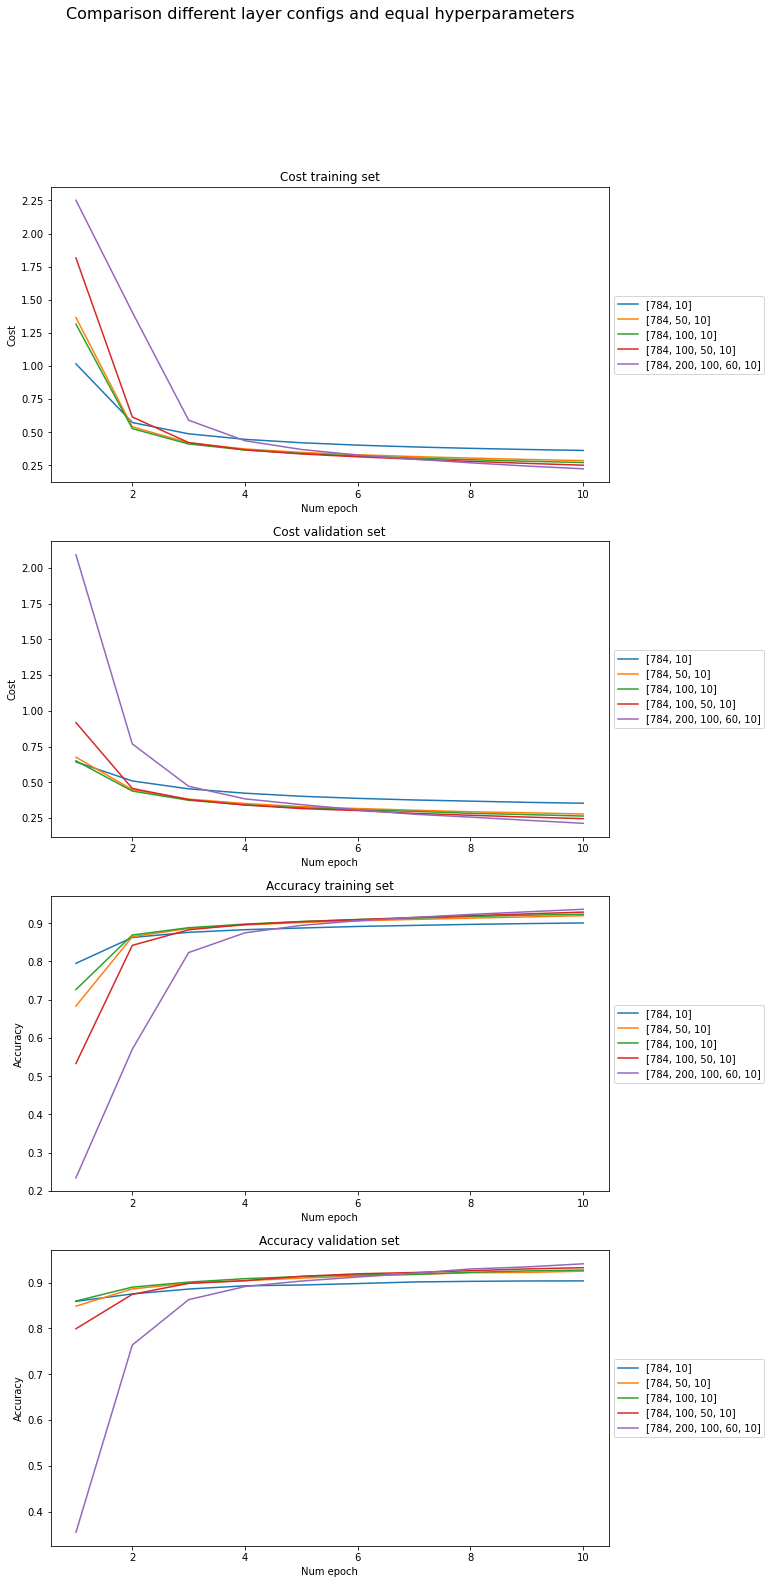

In [18]:
# Comparison plot
plot_comparable(results)

In [13]:
def build_score_table(results):
    table = pd.DataFrame(columns=['units', 'num_epochs', 'lr', 'batch_size', 'acc_train', 'acc_valid'])

    for result in results:
        max_entry = result.get_max_hist_entry()
        table.loc[len(table.index)] = max_entry
        table.reset_index(drop=True)
    return table

def find_result_by_units(results, units):
    return next(result for result in results if result.config.units == units)

In [14]:
# building and displaying score table
score_table = build_score_table(results)
score_table = score_table.sort_values(by="acc_valid", ascending=False)
score_table.reset_index(drop=True, inplace=True)
print(score_table)

                     units  num_epochs              lr  batch_size  acc_train  \
0  [784, 200, 100, 60, 10]          15  tensor(0.2300)          64   0.995611   
1       [784, 100, 50, 10]          15  tensor(0.2900)          64   0.996333   
2           [784, 100, 10]          15  tensor(0.4300)          64   0.998537   
3            [784, 50, 10]          15  tensor(0.3000)          64   0.986704   
4                [784, 10]          15  tensor(0.3900)          64   0.927056   

   acc_valid  
0   0.982833  
1   0.981000  
2   0.980500  
3   0.975667  
4   0.928833  


In [15]:
# evaluate test result for best model
best_result = find_result_by_units(results, score_table.loc[0]['units'])

best_model = best_result.get_max_model()

test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=True)

cost_ce_test = torch.nn.CrossEntropyLoss()

num_test_items = len(test_loader.dataset)
num_test_batches = len(test_loader)


# reset cost and correct item sum for epoch
sum_test_batch_cost = 0
sum_correct_item_test_batch = 0

with torch.no_grad():
    for batch_index, (X, Y) in enumerate(test_loader):
        pred = best_model(X)
        loss = cost_ce_test(pred, Y)

        sum_test_batch_cost += loss.item()
        sum_correct_item_test_batch += (Y == pred.argmax(dim=1)).type(torch.float).sum().item()

    test_cost = sum_test_batch_cost / num_test_batches
    test_acc = sum_correct_item_test_batch / num_test_items
    print("Cost test:", test_cost)
    print("Accuracy test:", test_acc)

Cost test: 0.08664988455266964
Accuracy test: 0.9798


In [16]:
# combined score_table with test result

score_table['acc_test'] = "-"
score_table.at[0, 'acc_test'] = test_acc

print(score_table)

                     units  num_epochs              lr  batch_size  acc_train  \
0  [784, 200, 100, 60, 10]          15  tensor(0.2300)          64   0.995611   
1       [784, 100, 50, 10]          15  tensor(0.2900)          64   0.996333   
2           [784, 100, 10]          15  tensor(0.4300)          64   0.998537   
3            [784, 50, 10]          15  tensor(0.3000)          64   0.986704   
4                [784, 10]          15  tensor(0.3900)          64   0.927056   

   acc_valid acc_test  
0   0.982833   0.9798  
1   0.981000        -  
2   0.980500        -  
3   0.975667        -  
4   0.928833        -  
